In [1]:
import numpy as np
# Create dataset
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
x = np.empty((m, 3))
x[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
x[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
x[:, 2] = x[:, 0] * w1 + x[:, 1] * w2 + noise * np.random.randn(m)

In [2]:
# Single value decomposition / manual PCA
x_centered = x - x.mean(axis=0)   #PCA needs data to be centered
U, s, Vt = np.linalg.svd(x_centered)
c1 = Vt.T[:, 0]   #Principle component 1
c2 = Vt.T[:, 1]   #Principle component 2

In [3]:
# Projecting the dataset to the PCs
W2 = Vt.T[:, :2]
x_2D = x_centered.dot(W2)

In [4]:
# PCA in sklearn
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
x_2D = pca.fit_transform(x)

pca.components_.T[:,0]   #Unit vector of the first PC

array([-0.93636116, -0.29854881, -0.18465208])

In [5]:
# Explained variance ratio
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

In [6]:
# Import MNIST
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

x = mnist['data']
y = mnist['target']

x_train, x_test, y_train, y_test = train_test_split(x, y)

In [7]:
# Choosing number of PCs
#(do PCA but without any reduction in dimensions, then find minimum with 95% variance explained)
pca = PCA()
pca.fit(x_train)
cum_sum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cum_sum >= 0.95) + 1

In [8]:
cum_sum #list of variance explained by each PC

array([0.09719832, 0.16875148, 0.23046024, 0.28447767, 0.33353621,
       0.37656401, 0.40934646, 0.43819275, 0.46567853, 0.48924485,
       0.51032629, 0.5307285 , 0.54778858, 0.56465048, 0.58041792,
       0.59534958, 0.60862878, 0.62147783, 0.63334578, 0.64479193,
       0.65545804, 0.66555448, 0.67514241, 0.68416896, 0.69296211,
       0.70131513, 0.70939893, 0.71727437, 0.72468736, 0.73157212,
       0.73812949, 0.74459959, 0.75058197, 0.75643475, 0.76210811,
       0.7675608 , 0.77261474, 0.77750626, 0.78230885, 0.78696883,
       0.79152081, 0.79597374, 0.80014325, 0.80411726, 0.80795962,
       0.81171266, 0.81533146, 0.81882001, 0.8221978 , 0.82541301,
       0.82859763, 0.83168676, 0.83465474, 0.83752128, 0.84034773,
       0.84303834, 0.84571815, 0.84828932, 0.85083357, 0.85329543,
       0.85569464, 0.8580644 , 0.86035289, 0.86256245, 0.86468703,
       0.86673787, 0.86875875, 0.87071732, 0.87263867, 0.87451472,
       0.87637902, 0.87817437, 0.87993644, 0.88167564, 0.88332

In [9]:
d

154

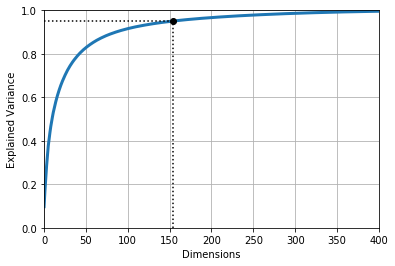

In [10]:
# Plot cumulative variance
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(6,4))
plt.plot(cum_sum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel('Dimensions')
plt.ylabel('Explained Variance')
plt.plot([d, d], [0, 0.95], 'k:')
plt.plot([0, d], [0.95, 0.95], 'k:')
plt.plot(d, 0.95, 'ko')
plt.grid(True)
plt.show()

In [11]:
# PCA but specifying desied variance instead of dimensions
pca = PCA(n_components=0.95)
x_reduced = pca.fit_transform(x_train)

In [12]:
# Inversing the PCA transormation
pca = PCA(n_components=154)
x_reduced = pca.fit_transform(x_train)
x_reconstructed = pca.inverse_transform(x_reduced)

In [13]:
# Randomized PCA
#(fatser than full SVD if required dimensions to present the data is much fewer than total dimensions)
rnd_pca = PCA(n_components=154, svd_solver='randomized') # change to 'full' for full SVD
x_rnd_reduced = rnd_pca.fit_transform(x_train)

In [15]:
# Incremental PCA
#(normal PCA require whole dataset to fit in memory, this doesnt)
from sklearn.decomposition import IncrementalPCA

n_batches = 100 # split into 100 increments
inc_pca = IncrementalPCA(n_components=154)
for batch in np.array_split(x_train, n_batches):
    inc_pca.partial_fit(batch)
x_inc_reduced = inc_pca.transform(x_train)

In [19]:
# Incremental PCA with numpy memmap
# Copy the dataset into memmep structure
filename = 'my_mnist.data'
m, n = x_train.shape

x_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m,n))
#x_mm[:] = x_train

In [17]:
# 'Now deleting the memmap() object will trigger its Python finalizer, which ensures that the data is saved to disk' (?)
# del x_mm

In [20]:
# Perform PCA on memmap
batch_size = m//n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(x_mm)

D:\anaconda\lib\site-packages\sklearn\decomposition\incremental_pca.py:282: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio = S ** 2 / np.sum(col_var * n_total_samples)


IncrementalPCA(batch_size=525, copy=True, n_components=154, whiten=False)

In [22]:
# Create dataset for kernel PCA example
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [24]:
# Kernel PCA
#(for complex nonlinear projection, similar to SVM kernel trick of creating new dimensions to make decision boundary simpler)
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.04) # kernel can also be 'linear' or 'sigmoid'
x_kernel_reduced = rbf_pca.fit_transform(X)

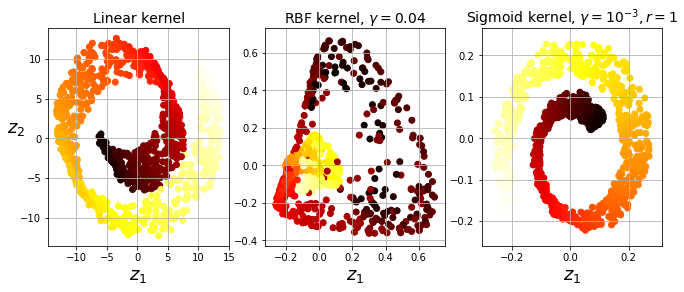

In [25]:
# Plotting different kernel types
lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

In [29]:
# Hyperparameter tuning PCA 
#(tune to objective at hand)
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ('kpca', KernelPCA(n_components=2)),
    ('log_reg', LogisticRegression(solver='lbfgs'))
])

param_grid = [{
    'kpca__gamma': np.linspace(0.03, 0.05, 10),
    'kpca__kernel': ['rbf', 'sigmoid']
}]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('kpca',
                                        KernelPCA(alpha=1.0, coef0=1,
                                                  copy_X=True, degree=3,
                                                  eigen_solver='auto',
                                                  fit_inverse_transform=False,
                                                  gamma=None, kernel='linear',
                                                  kernel_params=None,
                                                  max_iter=None, n_components=2,
                                                  n_jobs=None,
                                                  random_state=None,
                                                  remove_zero_eig=False,
                                                  tol=0)),
                                       ('log_reg',
                 

In [30]:
grid_search.best_params_

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}

In [ ]:
# Tuning by the reconstruction error

In [31]:
# Example PCA
rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.0433,
                   fit_inverse_transform=True)
x_reduced = rbf_pca.fit_transform(X)
x_preimage = rbf_pca.inverse_transform(x_reduced)
# Reconstruction error from the PCA
from sklearn.metrics import mean_squared_error

mean_squared_error(X, x_preimage)

32.786308795766125

In [32]:
# Use CV search to find parameter that minimizes above error







In [33]:
# locally Linear Embedding
#(1.calculate how each instance linearly relates to nearest instances)
#(2.looks for low dimension representation that best preserve the relationship)
#(good for twisted manifolds and there is not too much noise)
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
x_lle_reduced = lle.fit_transform(X)

In [ ]:
# Other techniques
# Random projection (sklearn.random_projection)
# Multidimensional Scaling
# Isomap
# t-SNE
# LDA